In [1]:
import matplotlib.pyplot as plt
import numpy as np

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('text.latex', preamble=r'\usepackage{pifont} ')

import scipy.integrate as si
import scipy.interpolate as sp
import scipy.optimize as so

Abs=np.abs
Log=np.log
Log10=np.log10
Pi=np.pi
ArcTanh=np.arctanh
Sqrt=np.sqrt
Exp=np.exp
HeavisideTheta=lambda x: np.heaviside(x,0)
def Plot(fun,xminmax,n=100):
    xlist=np.linspace(xminmax[0],xminmax[1],n)
    ylist=[fun(x) for x in xlist]
    plt.plot(xlist,ylist)
    
def root_concave(fun,bracket,rtol=1e-5):
    def newfun(x):
#         print ("x =", x)
        if x > bracket[1]:
#             print ("x too large:", x)
            return fun(bracket[1])+(x-bracket[1])
        if x < bracket[0]:
#             print ("x too small:", x)
            return fun(bracket[0])+(bracket[0]-x)
            
        y=fun(x)
        if y>=0:
            return y
        else:
            raise Exception('f<0 already found', x)
    try:      
        mini=so.minimize_scalar(newfun,bracket=bracket)#,options={"maxiter":10})
        if mini.fun>0: return None
        xmin=mini.x
    except Exception as inst:
#         print (inst.args)
        xmin=inst.args[1]
    sol1=so.root_scalar(fun,bracket=[bracket[0],xmin],rtol=rtol)
    sol2=so.root_scalar(fun,bracket=[xmin,bracket[1]],rtol=rtol)

    return sol1.root,sol2.root

In [2]:
flux_pi_ch=np.loadtxt("data/Le-Lmu-flux_pi_ch.csv",delimiter=",")
flux_K=np.loadtxt("data/Le-Lmu-flux_K.csv",delimiter=",")
def flux_data_fun(mz,data):#mz in GeV
    lgmz=np.log10(mz)
    if lgmz<data[0,0]:
        return 10**data[0,1]
    if lgmz>data[-1,0]:
        return 0
    return 10**np.interp(lgmz, data[:,0],data[:,1])

In [3]:
meson_distribution_data=np.loadtxt("data/meson_p_distribution.csv",delimiter=",")

def meson_z_fun0(z):#mz in GeV
    if z==0: return 0
    lgp=np.log10(z *120)
    if lgp>meson_distribution_data[-1,0]: return 0
    if lgp<meson_distribution_data[0,0]: return 10**meson_distribution_data[0,1]    
    return 10**np.interp(lgp,meson_distribution_data[:,0],meson_distribution_data[:,1])
meson_z_total=si.quad(meson_z_fun0,a=0,b=1,epsrel=1e-3) [0]
def meson_z_fun(z):
    return meson_z_fun0(z)/meson_z_total


In [4]:
ssss=str(np.loadtxt("data/z_expression.txt",dtype=str,delimiter="\n"))
ssss_pi=str(np.loadtxt("data/z_expression_pi.txt",dtype=str,delimiter="\n"))
ssss_eta=str(np.loadtxt("data/z_expression_eta.txt",dtype=str,delimiter="\n"))

    
area=Pi*(2.5e2)**2 #in the unit of cm^2,     
def dN_dz_prod_gp(z,m,g,mode="brem"):
#   production rate due to the coupling to proton/quark
    if mode== "brem":
        return area*g**2*eval(ssss) 
    if mode== "pi":
        return area*g**2*(eval(ssss_pi)) * meson_z_fun(z)
    if mode== "eta":
        return area*g**2*(eval(ssss_eta)) * meson_z_fun(z)
    if mode== "all":
        return dN_dz_prod_gp(z,m,g,mode="brem")+dN_dz_prod_gp(z,m,g,mode="pi")+\
                dN_dz_prod_gp(z,m,g,mode="eta")
    
def dN_dz_prod_gnu(z,m,g,mode="pi_ch"):
#   production rate due to the coupling to neutrino
    if mode== "pi_ch":
        return g**2*flux_data_fun(m,data=flux_pi_ch) * meson_z_fun(z)
    if mode== "K":
        return g**2*flux_data_fun(m,data=flux_K) * meson_z_fun(z)
    if mode== "all":
        return dN_dz_prod_gnu(z,m,g,mode="pi_ch")+dN_dz_prod_gnu(z,m,g,mode="K")
    
def dN_dz_prod(z,m,gnu,gp):
    return dN_dz_prod_gnu(z,m,gnu,mode="all")+dN_dz_prod_gp(z,m,gp,mode="all")
    

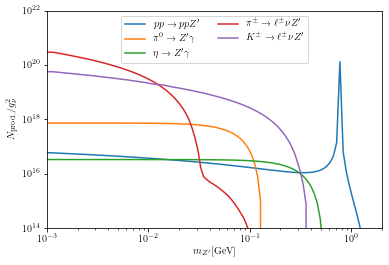

In [5]:
cut=5*1/120;


m_list=np.geomspace(1e-3,1.5,100)
N_list=[si.quad(lambda z: dN_dz_prod_gp(z,m,1e-2,mode="brem"), a=0,b=1-cut,epsrel=1e-3)[0] 
        for m in m_list]
plt.plot(m_list,N_list,label=r"$pp\rightarrow ppZ'$")

fun_list=[lambda z,m: dN_dz_prod_gp(z,m,1e-2,mode="pi"),
          lambda z,m: dN_dz_prod_gp(z,m,1e-2,mode="eta"),
          lambda z,m: dN_dz_prod_gnu(z,m,1,mode="pi_ch"),
          lambda z,m: dN_dz_prod_gnu(z,m,1,mode="K")
         ]

m_list=np.geomspace(1e-3,0.6,100)
for i,fun in enumerate(fun_list):
    N_list=[si.quad(lambda z:fun(z,m), a=0,b=1-cut,epsrel=1e-3)[0] for m in m_list]
    plt.plot(m_list,N_list,label=[r"$\pi^{0}\rightarrow Z'\gamma$",
                                  r"$\eta\rightarrow Z'\gamma$",
                                  r"$\pi^{\pm}\rightarrow\ell^{\pm}\nu Z'$",
                                  r"$K^{\pm}\rightarrow\ell^{\pm}\nu Z'$"
                                 ][i])

plt.loglog()
plt.xlabel(r"$m_{Z'} [{\rm GeV}]$")
plt.ylabel(r"$N_{\rm prod.}/g_{\nu}^2$")
plt.xlim(1e-3,2)
plt.ylim(1e14,1e22)
plt.legend(ncol=2)
# plt.savefig("../fig/flux_all.pdf",bbox_inches='tight')
plt.show()

In [6]:
meter=5.06842372022301e15 # * GeV^-1
GeV=1 # 
MeV=1e-3 *GeV

def P_decay(p,mA,decay_width,Lsh=579*meter,Ldec=5*meter): 
    if p==0: return 0
    v=p/Sqrt(mA**2+p**2)
    tau=1/decay_width
    global meanL
    meanL=tau*v/Sqrt(1-v**2)    
    return Exp(-Lsh/meanL)*(1-Exp(-Ldec/meanL))



gammasss="(g**2*mA*Sqrt(1 - (4*mf**2)/mA**2)*(1 + (2*mf**2)/mA**2))/(12.*Pi)"
m_mu=0.106 * GeV
m_e=0.511 * MeV
def decay_width(g,mA,mf=0,had=False):
    if mA<2*mf:
        return 0
    if not had:
        return eval(gammasss)
    else:
        if mA<Rhad_data[0,0]: return 0
        return eval(gammasss) * Rhad(mA)
    
Rhad_data=np.loadtxt("data/rpp2020-hadronicrpp_page1001.dat",usecols=[0,3])
def Rhad(m):
    if m<Rhad_data[0,0]:
        return 0
    if m>10:
        raise ValueError
    return np.interp(m,Rhad_data[:,0],Rhad_data[:,1])


E_p=120*GeV
_debug_turn_off_gnu_at_prod=False
def dN_dz(z,m,g,ratios={"nu":1,"e":1,"mu":1,"p":1}):  
    gmu=ratios["mu"]*g
    ge=ratios["e"]*g
    gnu=ratios["nu"]*g
    gp=ratios["p"]*g
    Gamma_mu=decay_width(gmu,m,mf=m_mu)
    Gamma_e=decay_width(ge,m,mf=m_e)
    Gamma_nu=decay_width(gnu,m,mf=0)
    Gamma_had=decay_width(gp,m,had=True)        
    Gamma_total=Gamma_mu+Gamma_e+Gamma_nu+Gamma_had
    BR=1-Gamma_nu/Gamma_total
    
    if _debug_turn_off_gnu_at_prod: gnu=0;
        
    return dN_dz_prod(z,m,gnu,gp)* P_decay(z*E_p, m, Gamma_total)*BR

def N_total(m,g,ratios={"nu":1,"e":1,"mu":1,"p":1}):
    iii=si.quad(lambda z: dN_dz(z,m,g,ratios=ratios),a=0,b=1-cut,epsrel=1e-03)
    return iii[0]

In [7]:
root_concave(lambda lgg:1-N_total(m=0.0012*GeV,g=10**lgg),bracket=[-10,-3])

(-7.812117881995226, -3.9453383211921915)

In [145]:
m_list0=np.concatenate([np.geomspace(1e-3,0.5,20),np.linspace(0.51,1.4,20)])*GeV;
# m_list=[1e-2,1]
roots=[]
for i,m in enumerate(m_list0):    
    print("\r",str(i),end="")
    double_root=root_concave(lambda lgg:1-N_total(m=m,g=10**lgg),
                             bracket=[-10,-3])
    if double_root==None:
        pass
    else:
        roots.append([m,10**double_root[0],10**double_root[1]])
roots=np.array(roots)

 39

[]

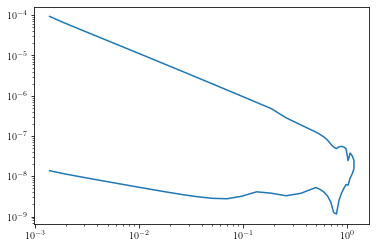

In [146]:
roots_combined=np.vstack([roots[:,[0,1]],np.flipud(roots[:,[0,2]])])
data=roots_combined
plt.plot(data[:,0],data[:,1])
plt.loglog()
# plt.savefig("../fig/bird.pdf",bbox_inches='tight')

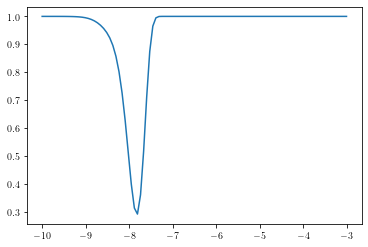

In [161]:
m=0.26;
Plot(lambda lgg:1-N_total(m=m,g=10**lgg,ratios={"nu":10,"e":1,"mu":1,"p":1}),
                             [-10,-3])

 9

[]

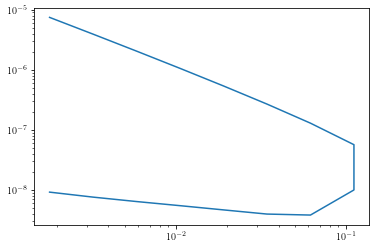

In [156]:
# m_list0=np.concatenate([np.geomspace(1e-3,0.5,3),np.linspace(0.51,1.4,3)])*GeV;
m_list0=np.geomspace(1e-3,0.2,10)
# m_list=[1e-2,1]
roots=[]
for i,m in enumerate(m_list0):    
    print("\r",str(i),end="")
    double_root=root_concave(lambda lgg:1-N_total(m=m,g=10**lgg,
                                                  ratios={"nu":10,"e":1,"mu":1,"p":1}),
                             bracket=[-10,-3])
    if double_root==None:
        pass
    else:
        roots.append([m,10**double_root[0],10**double_root[1]])
roots=np.array(roots)
roots_combined=np.vstack([roots[:,[0,1]],np.flipud(roots[:,[0,2]])])
data=roots_combined
plt.plot(data[:,0],data[:,1])
plt.loglog()

 9 r_nu= 100

[]

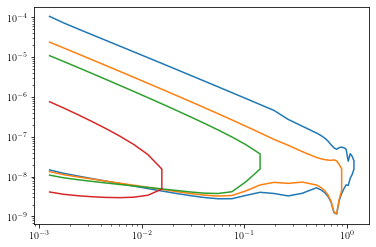

In [164]:
m_list0=np.concatenate([np.geomspace(1.26e-3,0.5,20),np.linspace(0.51,1.4,20)])*GeV;

for r_nu in [1,5,10,100]:
    roots=[]
    for i,m in enumerate(m_list0):    
        print("\r",str(i),"r_nu=",str(r_nu),end="")
        double_root=root_concave(lambda lgg:1-N_total(m=m,g=10**lgg,
                                                      ratios={"nu":r_nu,"e":1,"mu":1,"p":1}),
                                 bracket=[-10,-3])
        if double_root==None:
            break
        else:
            roots.append([m,10**double_root[0],10**double_root[1]])
    roots=np.array(roots)
    roots_combined=np.vstack([roots[:,[0,1]],np.flipud(roots[:,[0,2]])])
    data=roots_combined
    plt.plot(data[:,0],data[:,1])
    np.savetxt(r"data/bird_r"+str(r_nu)+".dat",data)
    
plt.loglog()

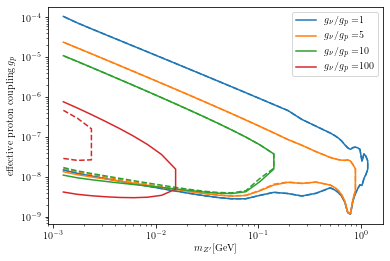

In [23]:
for i,r_nu in enumerate([1,5,10,100]):
    col="C"+str(i)
    data=np.loadtxt(r"data/bird_r"+str(r_nu)+".dat")
    plt.plot(data[:,0],data[:,1],label=r"$g_\nu/g_p=$"+str(r_nu),color=col)
    data=np.loadtxt(r"data/bird_r_wrong"+str(r_nu)+".dat")
    plt.plot(data[:,0],data[:,1],color=col,ls="--")
    
plt.legend()    
plt.loglog()
plt.xlabel(r"$m_{Z'} [{\rm GeV}]$")
plt.ylabel(r"effective proton coupling $g_p$")
# plt.savefig("../fig/bird.pdf",bbox_inches='tight')
plt.show()